In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import keras
import tensorflow as tf
import cv2
import os
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import shuffle

Generate Data From chest_xray Folder:

In [ ]:
labels = ['NORMAL', 'PNEUMONIA']  # NORMAL = 0 , PNEUMONIA = 1
IMG_SIZE = 150


#Concatenate all images in the different folders to three lists: normal, bacterial and virus

def get_training_data(data_dir):
    normal_data = []
    bacterial_data = []
    virus_data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                # Reshaping images to preferred size
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                if label == 'NORMAL':
                  normal_data.append([resized_arr, class_num])
                elif label == 'PNEUMONIA':
                  if "bacteria" in str(img):
                    bacterial_data.append([resized_arr, class_num])
                  elif "virus" in str(img):
                    virus_data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(normal_data), np.array(bacterial_data), np.array(virus_data)


# Includes both normal and pneumonia cases.
normal_data, bacterial_data, virus_data = get_training_data('/content/drive/MyDrive/Deep Learning Project/chest_xray/')  # list of [image, label]


<ipython-input-3-7522ecd7d707>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(normal_data), np.array(bacterial_data), np.array(virus_data)


Generate Train, Validation and Test Sets:

In [ ]:
SEED = 42
# Separate data and labels for each class
X_normal = [data[0] for data in normal_data]
y_normal = [data[1] for data in normal_data]

X_bacterial = [data[0] for data in bacterial_data]
y_bacterial = [data[1] for data in bacterial_data]

X_virus = [data[0] for data in virus_data]
y_virus = [data[1] for data in virus_data]

# Perform train-test split for each class separately
X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(X_normal, y_normal, test_size=0.15, random_state=SEED)
X_bacterial_train, X_bacterial_test, y_bacterial_train, y_bacterial_test = train_test_split(X_bacterial, y_bacterial, test_size=0.05, random_state=SEED)
X_virus_train, X_virus_test, y_virus_train, y_virus_test = train_test_split(X_virus, y_virus, test_size=0.075, random_state=SEED)

# Split the training sets into training and validation sets for each class
X_normal_train, X_normal_val, y_normal_train, y_normal_val = train_test_split(X_normal_train, y_normal_train, test_size=0.038, random_state=SEED)
X_bacterial_train, X_bacterial_val, y_bacterial_train, y_bacterial_val = train_test_split(X_bacterial_train, y_bacterial_train, test_size=0.0095, random_state=SEED)
X_virus_train, X_virus_val, y_virus_train, y_virus_val = train_test_split(X_virus_train, y_virus_train, test_size=0.019, random_state=SEED)

# Merge the data and labels for all classes
X_train = np.concatenate((X_normal_train, X_bacterial_train, X_virus_train), axis=0)
y_train = np.concatenate((y_normal_train, y_bacterial_train, y_virus_train), axis=0)
X_val = np.concatenate((X_normal_val, X_bacterial_val, X_virus_val), axis=0)
y_val = np.concatenate((y_normal_val, y_bacterial_val, y_virus_val), axis=0)
X_test = np.concatenate((X_normal_test, X_bacterial_test, X_virus_test), axis=0)
y_test = np.concatenate((y_normal_test, y_bacterial_test, y_virus_test), axis=0)

# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train, random_state=SEED)

# Normalize data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Reshape data for deep learning
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Rest of the code for data augmentation and model training
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False)

datagen.fit(X_train)


Building CNN network:

In [ ]:
kernelSize = (3,3)
poolSize = (2,2)
strideSize = (2,2)
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=kernelSize, padding='same',
                activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPool2D(pool_size=poolSize,strides=strideSize))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=kernelSize, padding="same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=kernelSize, padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=poolSize,strides=strideSize))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=kernelSize, padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=kernelSize, padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=poolSize,strides=strideSize))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=kernelSize, padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=kernelSize, padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=poolSize,strides=strideSize))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

Compile and Summerize The Model:

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy', metrics=['accuracy'])
# binary_crossentropy is chosen because we have a binary ouput, either sick or not.

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        3

Train the Model:

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.2, min_lr=0.00000001)
# min_delta: threshold for measuring the new optimum, to only focus on significant changes.

# early_stop = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=False)

# history = model.fit(X_train, y_train, batch_size=16,
#                     epochs=30, validation_data=(X_val, y_val), callbacks=[learning_rate_reduction, early_stop])
history = model.fit(X_train, y_train, batch_size=16,
                    epochs=20, validation_data=(X_val, y_val), callbacks=[learning_rate_reduction])


Epoch 1/20
329/329 [==============================] - 24s 40ms/step - loss: 0.2257 - accuracy: 0.9238 - val_loss: 2.6826 - val_accuracy: 0.5143 - lr: 0.0010
Epoch 2/20
329/329 [==============================] - 12s 35ms/step - loss: 0.1477 - accuracy: 0.9481 - val_loss: 0.1519 - val_accuracy: 0.9238 - lr: 0.0010
Epoch 3/20
329/329 [==============================] - 12s 36ms/step - loss: 0.1196 - accuracy: 0.9578 - val_loss: 0.2080 - val_accuracy: 0.9524 - lr: 0.0010
Epoch 4/20
329/329 [==============================] - 16s 49ms/step - loss: 0.0930 - accuracy: 0.9660 - val_loss: 0.2290 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 5/20
329/329 [==============================] - 12s 36ms/step - loss: 0.0910 - accuracy: 0.9685 - val_loss: 0.2009 - val_accuracy: 0.9524 - lr: 0.0010
Epoch 6/20
329/329 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9675
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
329/329 [==============================] -

Evaluate the Accuracy and Loss:

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

Test Loss: 0.2008369117975235
Test Accuracy: 0.9550102353096008


Plot Graphs of the Training and Validation Accuracy and Loss vs Epochs:

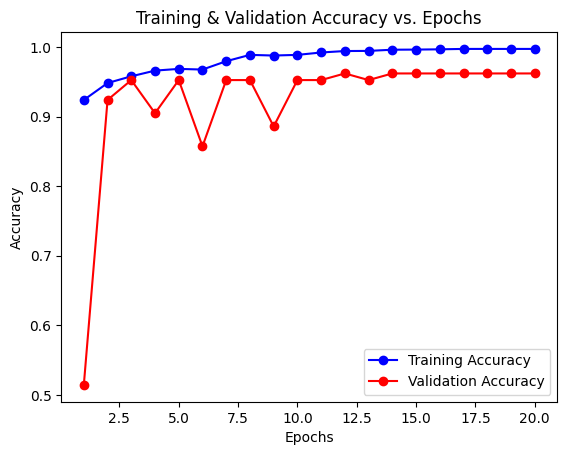

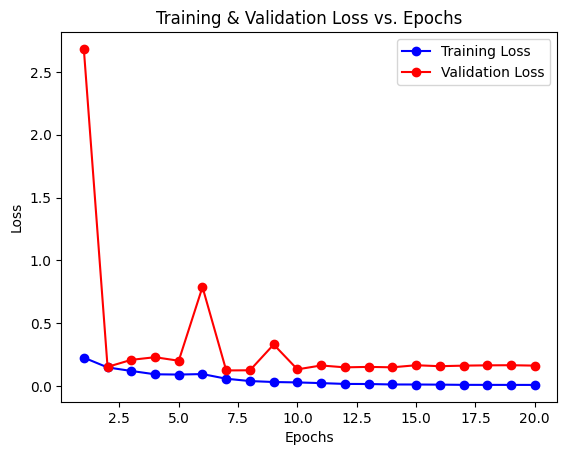

In [ ]:
accuracy_fig = plt.figure()
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy vs. Epochs')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

loss_fig = plt.figure()
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Training & Validation Loss vs. Epochs')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Precision vs. Recall Graph with f1-score point marked on it:

16/16 [==============================] - 0s 13ms/step
Threshold: 0.10, Precision: 0.91, Recall: 0.99
Threshold: 0.15, Precision: 0.91, Recall: 0.99
Threshold: 0.20, Precision: 0.92, Recall: 0.99
Threshold: 0.25, Precision: 0.92, Recall: 0.99
Threshold: 0.30, Precision: 0.92, Recall: 0.99
Threshold: 0.35, Precision: 0.92, Recall: 0.99
Threshold: 0.40, Precision: 0.93, Recall: 0.99
Threshold: 0.45, Precision: 0.93, Recall: 0.99
Threshold: 0.50, Precision: 0.93, Recall: 0.98
Threshold: 0.55, Precision: 0.93, Recall: 0.98
Threshold: 0.60, Precision: 0.93, Recall: 0.98
Threshold: 0.65, Precision: 0.94, Recall: 0.97
Threshold: 0.70, Precision: 0.94, Recall: 0.97
Threshold: 0.75, Precision: 0.94, Recall: 0.96
Threshold: 0.80, Precision: 0.94, Recall: 0.95
Threshold: 0.85, Precision: 0.94, Recall: 0.95
Threshold: 0.90, Precision: 0.95, Recall: 0.94


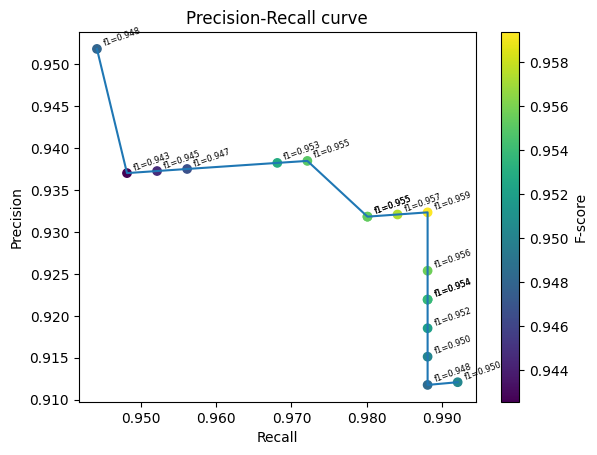

Maximum F1-score: 0.959
Corresponding threshold: 0.45


In [ ]:
y_scores = model.predict(X_test)  # X_test is the input data for testing

# y_true is the true binary labels
# y_scores is the predicted scores for each sample
# Define thresholds
thresholds = np.arange(0.1, 0.95, 0.05)

precision = []  # Initialize an empty list for precision scores
recall = []  # Initialize an empty list for recall scores

for t in thresholds:
    y_pred = y_scores > t
    p = precision_score(y_test, y_pred)
    r = recall_score(y_test, y_pred)
    precision.append(p)
    recall.append(r)
    print(f'Threshold: {t:.2f}, Precision: {p:.2f}, Recall: {r:.2f}')

f_scores = [f1_score(y_test, y_scores > t) for t in thresholds]

# plot the precision-recall curve
plt.plot(recall, precision)

# plot the F-score points per threshold on the precision-recall curve
plt.scatter(recall, precision, c=f_scores, cmap='viridis')
plt.colorbar(label='F-score')

# add text annotations with the F-score values
for r, p, f in zip(recall, precision, f_scores):
    plt.annotate(f'f1={f:.3f}', (r, p), xytext=(4, 2), textcoords='offset points', fontsize=6, rotation=20)

plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
# Set the number of digits after the decimal point on the x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
plt.show()

# Find the maximum F1-score and its corresponding threshold
max_f1_score = max(f_scores)
max_threshold = thresholds[f_scores.index(max_f1_score)]

print(f"Maximum F1-score: {max_f1_score:.3f}")
print(f"Corresponding threshold: {max_threshold:.2f}")
